In [1]:
import logging
from glob import glob

from live2p.workers import RealTimeQueue
from live2p.utils import (get_nchannels, get_nvols, 
                          get_tslice, ptoc, slice_movie, 
                          tic, get_true_mm3d_range)
from live2p.offline import run_plane_offline

# logging setup
# change for more or less information...
caiman_loglevel = logging.WARNING
live2p_loglevel = logging.DEBUG

# changes how logs/updates are printed
logformat = '{relativeCreated:08.0f} - {levelname:8} - [{module}:{funcName}:{lineno}] - {message}'
logging.basicConfig(level=caiman_loglevel, format=logformat, style='{') #sets caiman loglevel
logger = logging.getLogger('live2p')
logger.setLevel(live2p_loglevel) # sets live2p debug level

In [2]:
# experiment info
# put the makeMasks3D image mat file in the folder with your data
tiff_folder = 'e:/caiman_scratch/test_data/ori/data'

plane = 0 # index starts at 0 (for single plane)
nplanes = 3 # for running multiple planes
fr = 6.36

# x_start and x_end need to be the same or larger than what is in mm3d
# x_start = 110
# x_end = 512-110
# we can auto-determine them now...
# but note: if the stim/vis artifact is in the cropped range, there will be problems
# with motion correction and/or F extraction
mm3d_path = glob(tiff_folder + '/*.mat')[0]
x_start, x_end = get_true_mm3d_range(mm3d_path)
print(f'makeMasks3D range determine to be: {x_start} to {x_end} (pixels)')

# pre-allocated frame buffer, per plane
max_frames = 30000

n_init = 500

makeMasks3D range determine to be: 106 to 404 (pixels)


In [3]:
params = {
    'fr': fr,
    'p': 1,  # deconv 0 is off, 1 is slow, 2 is fast
    'nb': 3,  # background compenents -> nb: 3 for complex
    'decay_time': 1.0,  # sensor tau
    'gSig': (7, 7),  # expected half size of neurons in pixels, very important for proper component detection
    'init_method': 'seeded',
    'motion_correct': True,
    'expected_comps': 300,
    'update_num_comps': False,
    'update_freq': 100,
    'niter_rig': 2,
    'pw_rigid': False,
    'dist_shape_update': False,
    'normalize': True,
    'sniper_mode': False,
    'test_both': False,
    'ring_CNN': False,
    'simultaneously': True,
    'use_cuda': False,
}

In [4]:
# run a single plane offline
# result = run_plane_offline(plane, tiff_folder, params, x_start, x_end, n_init, max_frames)

In [ ]:
# run all planes offline
# as run_plane_offline is already multi-process, so the simplest way to do this is to run planes sequentially

t = tic()
data = []
for p in range(nplanes):
    print(f'***** Starting Plane {p} *****')
    result = run_plane_offline(p, tiff_folder, params, x_start, x_end, n_init, max_frames)
    data.append(result)
print('All done!')
ptoc(t, 'Whole thing took')

### Once that is all done the data is returned into a list of python dictionaries

So to access the results of a single plane, index into the list and then access fields in the dictionary with a string.

`data[plane_idx]['plane']` returns the plane number

`data[plane_idx]['C']` returns the denoised spatial components

`data[plane_idx]['nC']` returns the raw signal (or something close to it)

Note: the data is stored as lists NOT np.arrays, so to use them you need to convert them to arrays with `np.array(list)` or concatenate the lists (eg. C values for all planes) which will also return a np.array

In [6]:
data[0].keys()

dict_keys(['plane', 't', 'A', 'b', 'C', 'f', 'nC', 'YrA', 'CoM', 'dims', 'dff'])

### Make and save the data as a .mat:

In [7]:
import numpy as np
import scipy.io as sio

In [49]:
# make CoMs have z_value
planes = [0,1,2]
# planes = [0, 30 60]

locs = []
for i,dat in enumerate(data):
    z_plane = planes[i]
    coms = np.array(dat['CoM'], dtype=int)
    ps = np.full((coms.shape[0],1), fill_value=z_plane)
    xyz = np.hstack((coms, ps))
    locs.append(xyz)
    
locs = np.vstack(locs)

In [50]:
# c is denoiced, nC is raw, a is spatial
c = np.concatenate([dat['C'] for dat in data])
nC = np.concatenate([dat['nC'] for dat in data])
a = np.hstack([dat['A'] for dat in data])

In [ ]:
mat = {
    'c':c,
    'nC':nC,
    'a':a,
    'locs':locs
}

fpath_to_save = 'path/to/save/fname.mat'
sio.savemat(fpath_to_save, mat)

## Play with data in python

In [55]:
import matplotlib.pyplot as plt

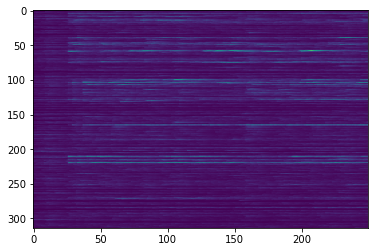

In [56]:
plt.imshow(c[:,:250], aspect='auto')

Text(0.5, 0.98, 'Denoised Traces')

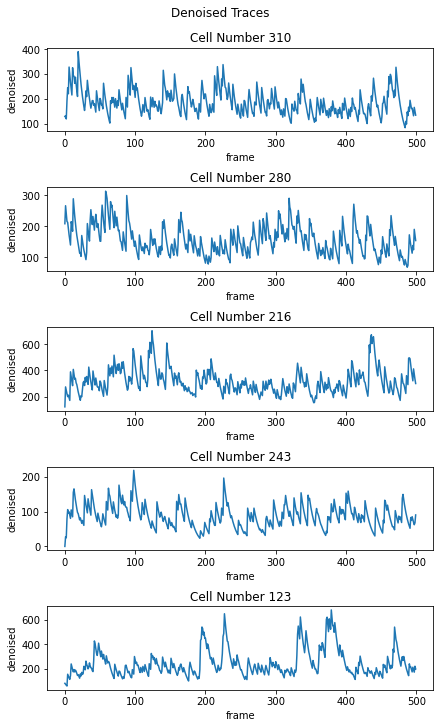

In [61]:
randcells = np.random.choice(np.arange(c.shape[0]), 5, replace=False)
fig, axes = plt.subplots(5,1, constrained_layout=True, figsize=(6,10))

for ax,rc in zip(axes, randcells):
    ax.plot(c[rc, :500])
    ax.set_title(f'Cell Number {rc}')
    ax.set_ylabel('denoised')
    ax.set_xlabel('frame')
    
fig.suptitle('Denoised Traces')

Text(0.5, 0.98, 'Noisy Traces')

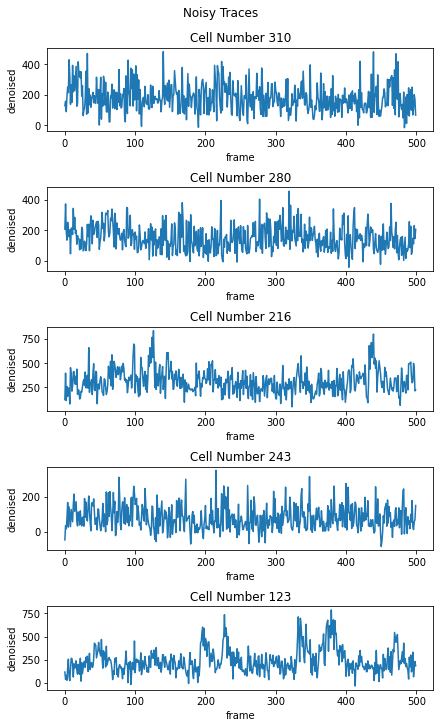

In [74]:
# randcells = np.random.choice(np.arange(c.shape[0]), 5, replace=False)
fig, axes = plt.subplots(5,1, constrained_layout=True, figsize=(6,10))

for ax,rc in zip(axes, randcells):
    ax.plot(nC[rc, :500])
    ax.set_title(f'Cell Number {rc}')
    ax.set_ylabel('denoised')
    ax.set_xlabel('frame')
    
fig.suptitle('Noisy Traces')

In [68]:
dims = data[0]['dims']
a2 = a.reshape((*dims, -1), order='F')
a2.shape

(512, 298, 314)

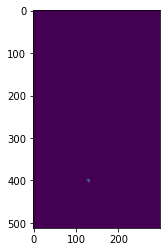

In [73]:
cell = 55
plt.imshow(a2[:,:,cell])